In [1]:
import pennylane as qml
import tensorflow as tf
import numpy as np
import pandas as pd
import gc
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Set random seed
np.random.seed(42)

# Load the TLS network traffic dataset
dataset_path = "E:\\Studies\\IIT\\4 - Forth Year\\Final Year Project\\QuanNetDetct\\Model\\Datasets\\Darknet\\Darknet.csv"
darknet_data = pd.read_csv(dataset_path)

# Filter only TLS traffic
tls_ports = [443, 993, 995, 465, 8443]
tls_traffic = darknet_data[(darknet_data['Dst Port'].isin(tls_ports)) & (darknet_data['Protocol'] == 6)].copy()

# Encode categorical columns
label_encoder = LabelEncoder()
for col in tls_traffic.select_dtypes(include=['object']).columns:
    tls_traffic[col] = label_encoder.fit_transform(tls_traffic[col])

# Select numeric columns and scale
tls_traffic = tls_traffic.drop(columns=['Flow ID', 'Src IP', 'Dst IP', 'Timestamp'], errors='ignore')
numeric_columns = tls_traffic.select_dtypes(include=['float64', 'int64']).columns

# Handle Missing & Extreme Values
tls_traffic[numeric_columns] = tls_traffic[numeric_columns].replace([np.inf, -np.inf], np.nan)
tls_traffic[numeric_columns] = tls_traffic[numeric_columns].fillna(tls_traffic[numeric_columns].mean())

# Clip extreme values (1st and 99th percentiles)
tls_traffic[numeric_columns] = tls_traffic[numeric_columns].clip(
    lower=tls_traffic[numeric_columns].quantile(0.01),
    upper=tls_traffic[numeric_columns].quantile(0.99),
    axis=1
)

# Apply MinMax Scaling
tls_traffic[numeric_columns] = MinMaxScaler().fit_transform(tls_traffic[numeric_columns])

gc.collect()

# Apply SMOTE to handle class imbalance
X = tls_traffic.drop('Label', axis=1)
y = tls_traffic['Label']
smote = SMOTE(sampling_strategy='auto', random_state=42)
X, y = smote.fit_resample(X, y)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

tf.keras.backend.clear_session()

# Define Quantum Circuit
dev = qml.device("default.qubit", wires=3)

@qml.qnode(dev, interface="tf")
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(3), rotation="Y")
    qml.StronglyEntanglingLayers(weights, wires=range(3))
    return [qml.expval(qml.PauliZ(i)) for i in range(3)]

# Define Quantum Layer
class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self, num_qubits, **kwargs):
        super(QuantumLayer, self).__init__(**kwargs)
        self.num_qubits = num_qubits
        self.q_weights = self.add_weight(name="q_weights", shape=(1, num_qubits), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        return tf.random.uniform((tf.shape(inputs)[0], self.num_qubits))

    def get_config(self):
        config = super().get_config()
        config.update({"num_qubits": self.num_qubits})
        return config

def create_hybrid_gru_model(num_features, num_classes=4):
    input_layer = tf.keras.layers.Input(shape=(num_features, 1))
    
    # Quantum Layer
    quantum_layer = QuantumLayer(3)(input_layer)
    quantum_layer = tf.keras.layers.Dense(32, activation="relu")(quantum_layer)
    
    # GRU Layer
    gru_layer = tf.keras.layers.GRU(64, return_sequences=True, dropout=0.3)(input_layer)
    gru_layer = tf.keras.layers.BatchNormalization()(gru_layer)
    gru_layer = tf.keras.layers.GRU(32, return_sequences=False, dropout=0.3)(gru_layer)
    gru_layer = tf.keras.layers.BatchNormalization()(gru_layer)
    
    # Combine Quantum and Classical Features
    combined = tf.keras.layers.concatenate([quantum_layer, gru_layer])
    
    # Fully Connected Layers
    dense_layer = tf.keras.layers.Dense(64, activation='relu')(combined)
    dense_layer = tf.keras.layers.Dropout(0.3)(dense_layer)
    dense_layer = tf.keras.layers.Dense(32, activation='relu')(dense_layer)
    
    # Output Layer
    output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(dense_layer)
    
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

# Reshape input for GRU
X_train_reshaped = np.expand_dims(X_train, axis=-1)
X_test_reshaped = np.expand_dims(X_test, axis=-1)

# Convert labels to categorical format
y_train_categorical = to_categorical(y_train, num_classes=4)
y_test_categorical = to_categorical(y_test, num_classes=4)

# Create and compile the model
gru_model = create_hybrid_gru_model(X_train.shape[1])
gru_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")])

# Train the Model
history = gru_model.fit(
    X_train_reshaped, y_train_categorical,
    validation_data=(X_test_reshaped, y_test_categorical),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Save the trained model
gru_model.save("E:\\Studies\\IIT\\4 - Forth Year\\Final Year Project\\QuanNetDetct\\Model\\hybrid_gru_model.h5")
print("Hybrid Quantum GRU Model saved successfully.")

Epoch 1/10
1140/1140 [==============================] - 12s 8ms/step - loss: 1.1323 - accuracy: 0.4941 - precision: 0.6846 - recall: 0.2315 - val_loss: 1.6800 - val_accuracy: 0.5716 - val_precision: 0.6013 - val_recall: 0.4186
Epoch 2/10
1140/1140 [==============================] - 9s 8ms/step - loss: 0.8217 - accuracy: 0.6632 - precision: 0.7557 - recall: 0.5364 - val_loss: 1.2905 - val_accuracy: 0.6675 - val_precision: 0.6946 - val_recall: 0.5765
Epoch 3/10
1140/1140 [==============================] - 12s 11ms/step - loss: 0.6875 - accuracy: 0.7186 - precision: 0.7868 - recall: 0.6316 - val_loss: 1.7540 - val_accuracy: 0.5607 - val_precision: 0.5664 - val_recall: 0.4819
Epoch 4/10
1140/1140 [==============================] - 10s 9ms/step - loss: 0.6413 - accuracy: 0.7332 - precision: 0.7994 - recall: 0.6518 - val_loss: 2.3019 - val_accuracy: 0.5353 - val_precision: 0.5410 - val_recall: 0.4920
Epoch 5/10
1140/1140 [==============================] - 11s 10ms/step - loss: 0.6138 - accur

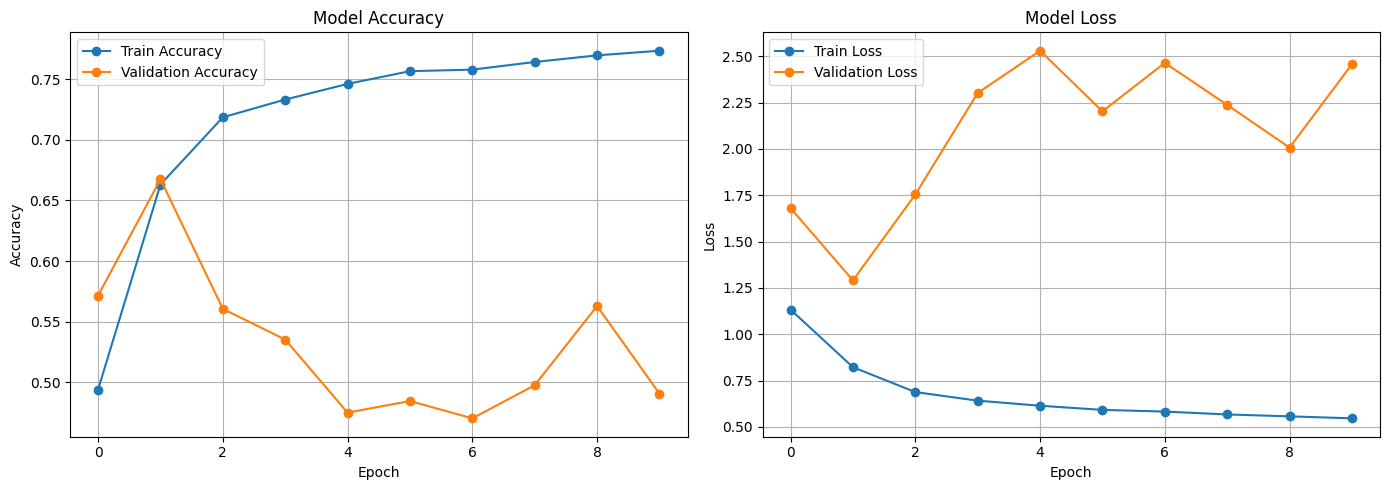

285/285 [==============================] - 1s 3ms/step

Test Performance Metrics:
Accuracy  : 0.4909
Precision : 0.5324
Recall    : 0.4909
F1 Score  : 0.4584

lassification Report:
              precision    recall  f1-score   support

           0       0.44      0.46      0.45      2279
           1       0.41      0.30      0.35      2279
           2       0.50      0.95      0.66      2279
           3       0.78      0.25      0.38      2279

    accuracy                           0.49      9116
   macro avg       0.53      0.49      0.46      9116
weighted avg       0.53      0.49      0.46      9116



In [3]:
# Plot Training & Validation Accuracy and Loss
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ----------------------------
# Evaluation on Test Set
# ----------------------------

# Get predicted class labels
y_pred_probs = gru_model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Calculate Metrics
test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='macro')
test_recall = recall_score(y_true, y_pred, average='macro')
test_f1 = f1_score(y_true, y_pred, average='macro')

# Display metrics
print("\nTest Performance Metrics:")
print(f"Accuracy  : {test_accuracy:.4f}")
print(f"Precision : {test_precision:.4f}")
print(f"Recall    : {test_recall:.4f}")
print(f"F1 Score  : {test_f1:.4f}")

# Classification Report
print("\nlassification Report:")
print(classification_report(y_true, y_pred))